# 🌦️ Data Exploration — WeatherBench2 ERA5

This notebook explores the WeatherBench2 ERA5 dataset used for training
the Weather Transformer model.

**Contents:**
1. Load raw ERA5 data
2. Inspect variables, shapes, and coordinate systems
3. Visualize sample weather maps for each variable
4. Compute and display data statistics
5. Verify preprocessing (normalization, train/val/test splits)

In [1]:
import sys
from pathlib import Path

# Add project root to path
sys.path.insert(0, str(Path.cwd().parent))

import numpy as np
import matplotlib.pyplot as plt

try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    HAS_CARTOPY = True
except ImportError:
    HAS_CARTOPY = False
    print("cartopy not installed — using simple plots")

print("✅ Setup complete")

✅ Setup complete


## 1. Load Processed Data

We load the preprocessed `.npy` files created by `src/data/preprocessing.py`.
These contain normalized weather variables stacked as `(N, C, H, W)` tensors.

In [2]:
import json

DATA_DIR = Path("../data/processed")

# Variable names
VARIABLES = ["t850", "z500", "u10", "v10"]
VARIABLE_DESCRIPTIONS = {
    "t850": "Temperature at 850 hPa (K)",
    "z500": "Geopotential at 500 hPa (m²/s²)",
    "u10": "U-component of wind at 10m (m/s)",
    "v10": "V-component of wind at 10m (m/s)",
}

# Load splits
splits = {}
for split in ["train", "val", "test"]:
    inputs_path = DATA_DIR / f"{split}_inputs.npy"
    targets_path = DATA_DIR / f"{split}_targets.npy"
    
    if inputs_path.exists():
        splits[split] = {
            "inputs": np.load(inputs_path),
            "targets": np.load(targets_path),
        }
        print(f"✅ {split}: inputs {splits[split]['inputs'].shape}, targets {splits[split]['targets'].shape}")
    else:
        print(f"⚠️  {split} data not found at {inputs_path}")

# Load normalization stats from metadata.json
stats_path = DATA_DIR / "metadata.json"
if stats_path.exists():
    with open(stats_path) as f:
        metadata = json.load(f)
    norm_stats = metadata.get("normalization", None)
    print(f"\n📊 Normalization stats loaded: {list(norm_stats.keys()) if norm_stats else 'None'}")
else:
    norm_stats = None
    metadata = None
    print("⚠️  No metadata found")

✅ train: inputs (5843, 4, 32, 64), targets (5843, 4, 32, 64)
✅ val: inputs (1459, 4, 32, 64), targets (1459, 4, 32, 64)
✅ test: inputs (1463, 4, 32, 64), targets (1463, 4, 32, 64)

📊 Normalization stats loaded: ['t850', 'z500', 'u10', 'v10']


## 2. Data Shape & Structure

Each sample has shape `(C, H, W)` = `(4, 32, 64)`:
- **C = 4**: weather variables (t850, z500, u10, v10)
- **H = 32**: latitude points (~5.625° resolution)
- **W = 64**: longitude points (~5.625° resolution)

In [3]:
if splits:
    first_split = list(splits.keys())[0]
    sample = splits[first_split]["inputs"]
    
    print("=" * 50)
    print("DATA STRUCTURE SUMMARY")
    print("=" * 50)
    print(f"Sample shape:    {sample.shape[1:]} (C, H, W)")
    print(f"Grid resolution: {180/sample.shape[2]:.3f}° lat × {360/sample.shape[3]:.3f}° lon")
    print(f"Variables:       {VARIABLES}")
    print(f"Dtype:           {sample.dtype}")
    print()
    
    print("Split sizes:")
    for name, data in splits.items():
        n = data["inputs"].shape[0]
        hours = n * 6
        days = hours / 24
        print(f"  {name:5s}: {n:6d} samples ({days:.0f} days / {hours} hours)")
    
    total = sum(d["inputs"].shape[0] for d in splits.values())
    print(f"  {'total':5s}: {total:6d} samples")

DATA STRUCTURE SUMMARY
Sample shape:    (4, 32, 64) (C, H, W)
Grid resolution: 5.625° lat × 5.625° lon
Variables:       ['t850', 'z500', 'u10', 'v10']
Dtype:           float32

Split sizes:
  train:   5843 samples (1461 days / 35058 hours)
  val  :   1459 samples (365 days / 8754 hours)
  test :   1463 samples (366 days / 8778 hours)
  total:   8765 samples


## 3. Per-Variable Statistics

After z-score normalization, each variable should have
**mean ≈ 0** and **std ≈ 1** on the training set.

In [4]:
if splits and "train" in splits:
    train_inputs = splits["train"]["inputs"]
    
    print("Per-Variable Statistics (Training Set, Normalized)")
    print("=" * 60)
    print(f"{'Variable':<10} {'Mean':>10} {'Std':>10} {'Min':>10} {'Max':>10}")
    print("-" * 60)
    
    for i, var in enumerate(VARIABLES):
        channel = train_inputs[:, i, :, :]
        print(f"{var:<10} {channel.mean():>10.4f} {channel.std():>10.4f} "
              f"{channel.min():>10.4f} {channel.max():>10.4f}")
    
    print("-" * 60)
    print(f"{'Overall':<10} {train_inputs.mean():>10.4f} {train_inputs.std():>10.4f} "
          f"{train_inputs.min():>10.4f} {train_inputs.max():>10.4f}")
    
    # Show original scale if norm_stats available
    if norm_stats:
        print("\n\nOriginal Scale (before normalization):")
        print("=" * 50)
        print(f"{'Variable':<10} {'Mean':>12} {'Std':>12}")
        print("-" * 50)
        for var, stats in norm_stats.items():
            print(f"{var:<10} {stats['mean']:>12.2f} {stats['std']:>12.2f}")

Per-Variable Statistics (Training Set, Normalized)
Variable         Mean        Std        Min        Max
------------------------------------------------------------
t850           0.0000     1.0000    -3.5966     2.3190
z500           0.0000     1.0000    -3.1087     1.3976
u10            0.0000     1.0000    -4.9623     4.9702
v10            0.0000     1.0000    -5.3204     6.0566
------------------------------------------------------------
Overall        0.0000     1.0000    -5.3204     6.0566


Original Scale (before normalization):
Variable           Mean          Std
--------------------------------------------------
t850             275.15        15.29
z500           54208.52      3389.13
u10               -0.03         5.10
v10                0.20         4.34


## 4. Visualize Sample Weather Maps

Plotting a single timestep for all 4 variables on the global grid.

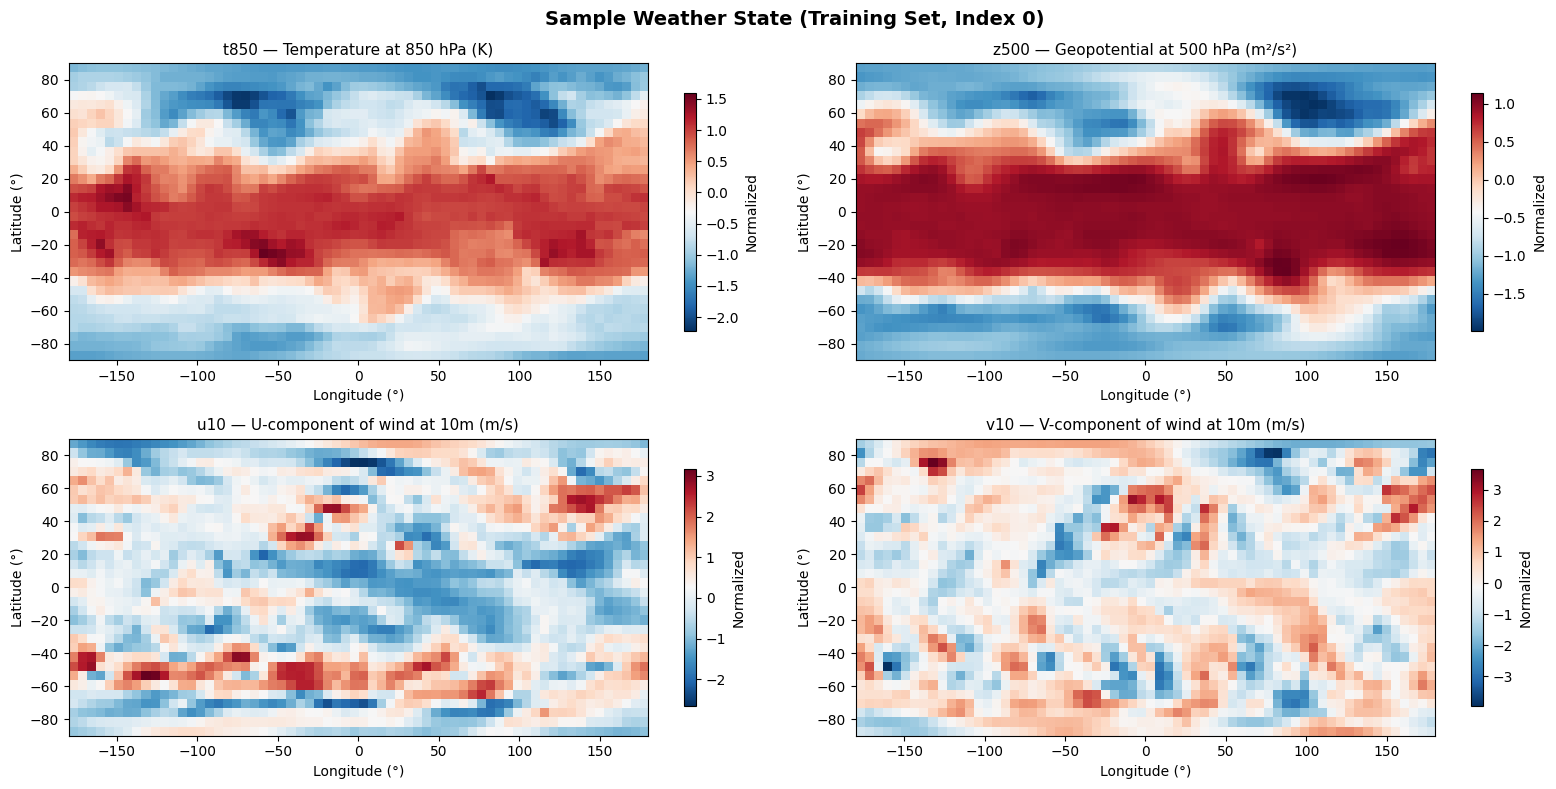

✅ Saved to results/figures/data_exploration_sample.png


In [5]:
if splits and "train" in splits:
    sample_idx = 0
    sample = splits["train"]["inputs"][sample_idx]  # (C, H, W)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 8))
    fig.suptitle(f"Sample Weather State (Training Set, Index {sample_idx})", 
                 fontsize=14, fontweight="bold")
    
    for i, (ax, var) in enumerate(zip(axes.flat, VARIABLES)):
        data = sample[i]
        
        im = ax.imshow(data, cmap="RdBu_r", origin="lower",
                       extent=[-180, 180, -90, 90], aspect="auto")
        ax.set_title(f"{var} — {VARIABLE_DESCRIPTIONS[var]}", fontsize=11)
        ax.set_xlabel("Longitude (°)")
        ax.set_ylabel("Latitude (°)")
        plt.colorbar(im, ax=ax, shrink=0.8, label="Normalized")
    
    plt.tight_layout()
    plt.savefig("../results/figures/data_exploration_sample.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("✅ Saved to results/figures/data_exploration_sample.png")

## 5. Input vs Target Comparison

The model predicts `Y(t+6h)` from `X(t)`. Let's visualize
how much changes in 6 hours.

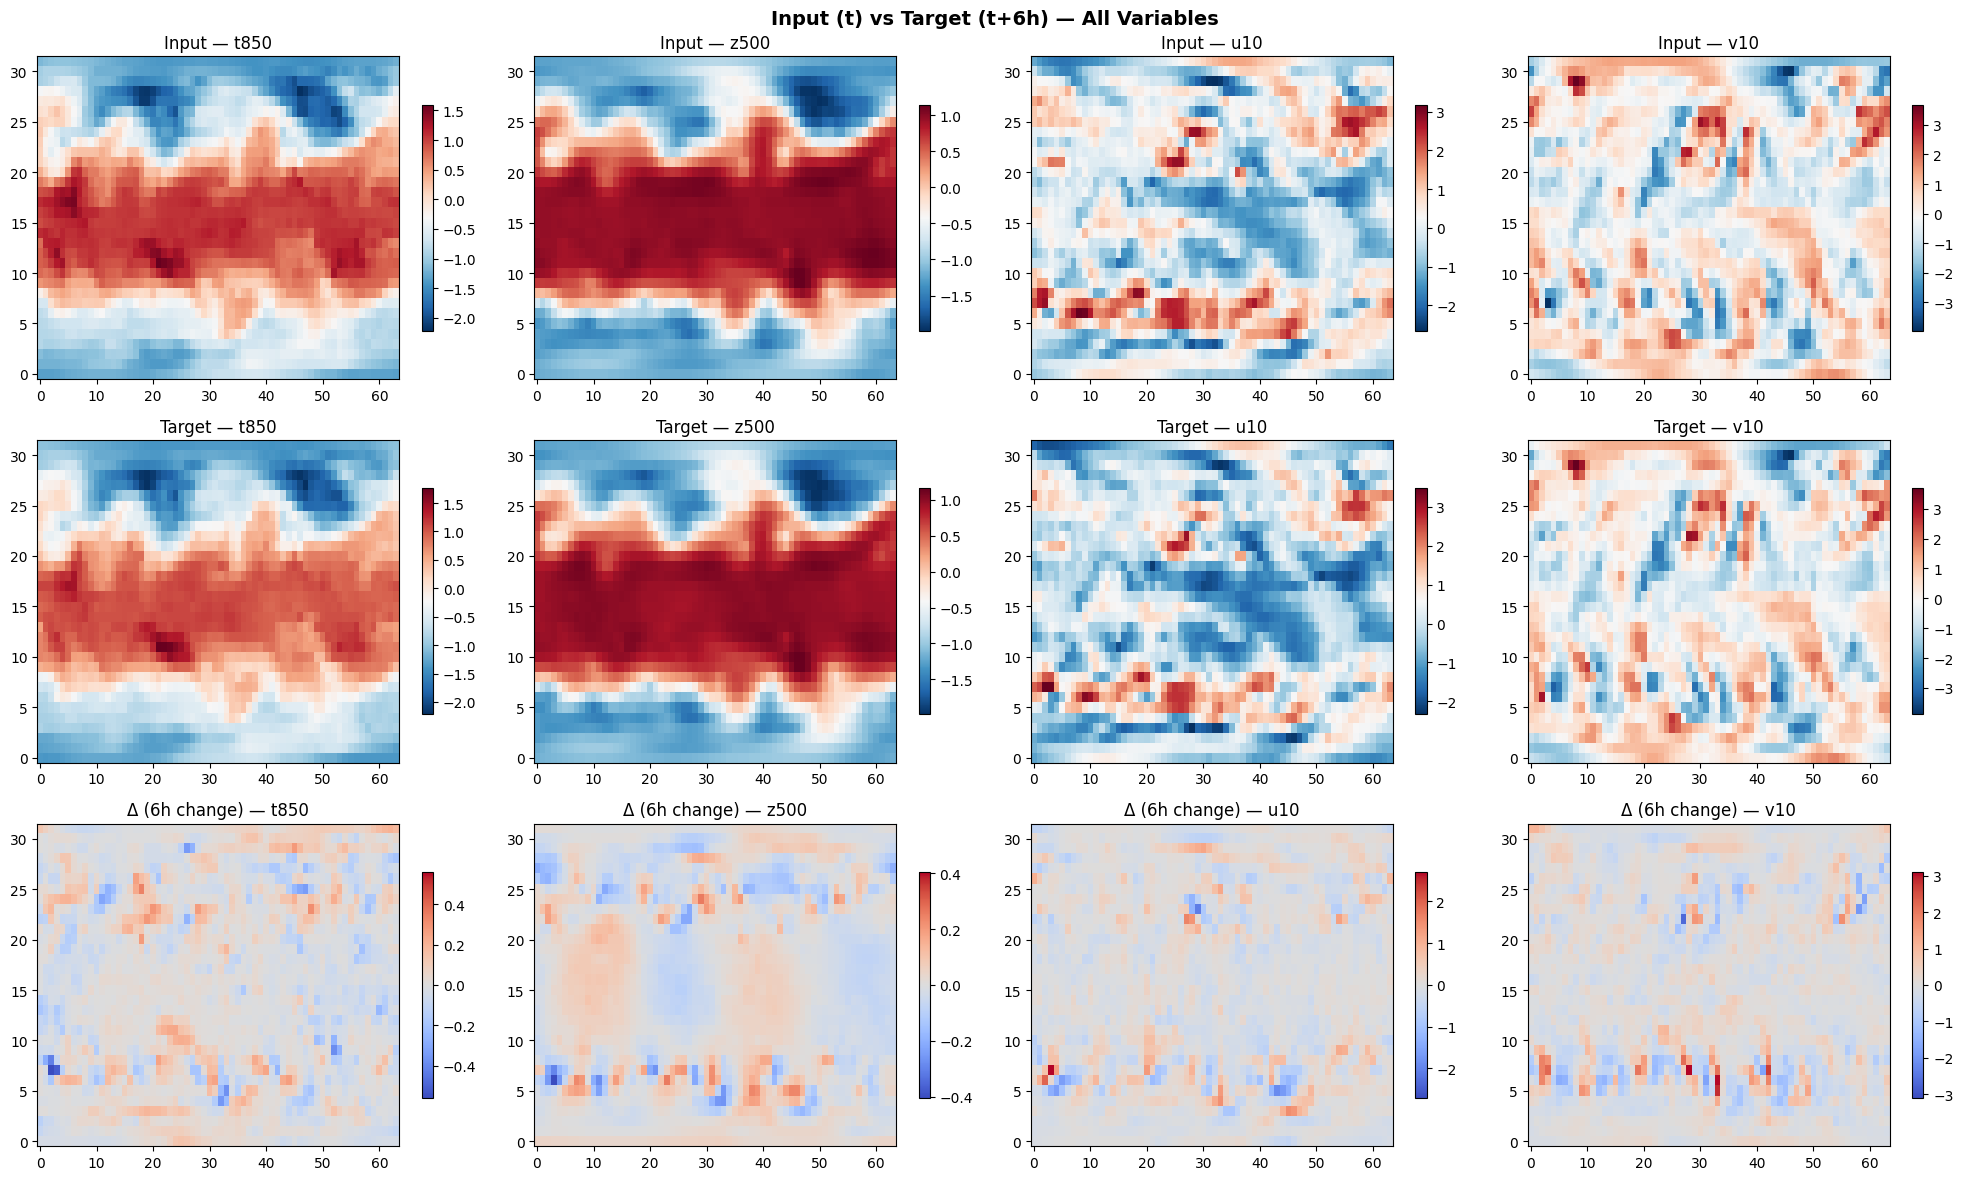


6-Hour Change Statistics (normalized units):
Variable       Mean Δ      Std Δ    Max |Δ|
---------------------------------------------
t850           0.0017     0.0792     0.5595
z500          -0.0005     0.0649     0.4042
u10           -0.0135     0.3126     2.7041
v10           -0.0039     0.4138     3.0990


In [6]:
if splits and "train" in splits:
    idx = 0
    inp = splits["train"]["inputs"][idx]    # (C, H, W)
    tgt = splits["train"]["targets"][idx]   # (C, H, W)
    diff = tgt - inp
    
    fig, axes = plt.subplots(3, 4, figsize=(20, 12))
    fig.suptitle("Input (t) vs Target (t+6h) — All Variables", fontsize=14, fontweight="bold")
    
    for i, var in enumerate(VARIABLES):
        # Row 0: Input
        im0 = axes[0, i].imshow(inp[i], cmap="RdBu_r", origin="lower", aspect="auto")
        axes[0, i].set_title(f"Input — {var}")
        plt.colorbar(im0, ax=axes[0, i], shrink=0.7)
        
        # Row 1: Target
        im1 = axes[1, i].imshow(tgt[i], cmap="RdBu_r", origin="lower", aspect="auto")
        axes[1, i].set_title(f"Target — {var}")
        plt.colorbar(im1, ax=axes[1, i], shrink=0.7)
        
        # Row 2: Difference
        abs_max = max(abs(diff[i].min()), abs(diff[i].max()))
        im2 = axes[2, i].imshow(diff[i], cmap="coolwarm", origin="lower", aspect="auto",
                                vmin=-abs_max, vmax=abs_max)
        axes[2, i].set_title(f"Δ (6h change) — {var}")
        plt.colorbar(im2, ax=axes[2, i], shrink=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Print change statistics
    print("\n6-Hour Change Statistics (normalized units):")
    print(f"{'Variable':<10} {'Mean Δ':>10} {'Std Δ':>10} {'Max |Δ|':>10}")
    print("-" * 45)
    for i, var in enumerate(VARIABLES):
        d = diff[i]
        print(f"{var:<10} {d.mean():>10.4f} {d.std():>10.4f} {np.abs(d).max():>10.4f}")

## 6. Distribution of Values

Histograms showing the distribution of each variable
across the training set.

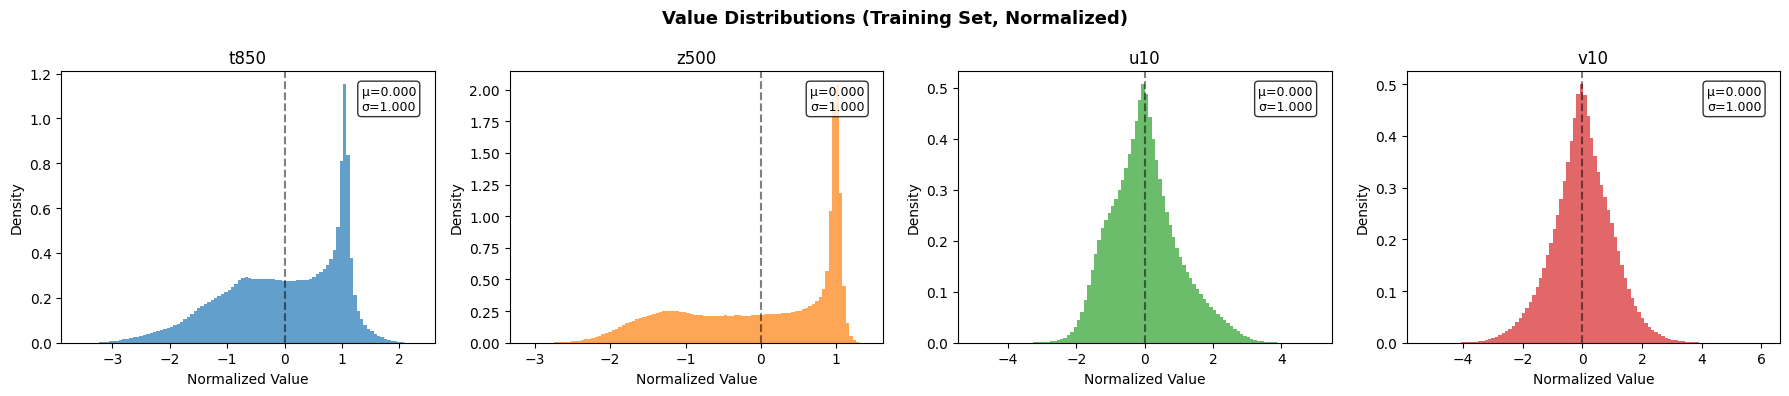

In [7]:
if splits and "train" in splits:
    fig, axes = plt.subplots(1, 4, figsize=(18, 4))
    fig.suptitle("Value Distributions (Training Set, Normalized)", fontsize=13, fontweight="bold")
    
    for i, (ax, var) in enumerate(zip(axes, VARIABLES)):
        data = splits["train"]["inputs"][:, i, :, :].flatten()
        
        ax.hist(data, bins=100, density=True, alpha=0.7, color=f"C{i}", edgecolor="none")
        ax.axvline(0, color="k", linestyle="--", alpha=0.5)
        ax.set_title(f"{var}")
        ax.set_xlabel("Normalized Value")
        ax.set_ylabel("Density")
        ax.text(0.95, 0.95, f"μ={data.mean():.3f}\nσ={data.std():.3f}",
                transform=ax.transAxes, ha="right", va="top",
                fontsize=9, bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    plt.show()

## 7. Spatial Correlation

Weather variables are spatially correlated —
nearby grid cells have similar values. This is what
the transformer's attention mechanism should learn to exploit.

In [8]:
if splits and "train" in splits:
    # Compute average spatial autocorrelation for t850
    sample = splits["train"]["inputs"][:100, 0, :, :]  # First 100 samples, t850
    
    # Correlation between adjacent cells (lag-1)
    lat_corr = np.corrcoef(sample[:, :-1, :].flatten(), sample[:, 1:, :].flatten())[0, 1]
    lon_corr = np.corrcoef(sample[:, :, :-1].flatten(), sample[:, :, 1:].flatten())[0, 1]
    
    print("Spatial Autocorrelation (t850, first 100 samples):")
    print(f"  Latitude  (lag-1): {lat_corr:.4f}")
    print(f"  Longitude (lag-1): {lon_corr:.4f}")
    print(f"\n→ High correlation confirms spatial smoothness in weather data.")
    print(f"→ This justifies our spatial smoothness loss constraint.")

Spatial Autocorrelation (t850, first 100 samples):
  Latitude  (lag-1): 0.9594
  Longitude (lag-1): 0.9907

→ High correlation confirms spatial smoothness in weather data.
→ This justifies our spatial smoothness loss constraint.


## Summary

| Property | Value |
|---|---|
| Grid size | 32 × 64 (lat × lon) |
| Resolution | ~5.625° |
| Variables | t850, z500, u10, v10 |
| Temporal resolution | 6-hourly |
| Train/Val/Test | By year (2015-2018 / 2019 / 2020) |
| Normalization | Z-score (per-variable, from train only) |

**Key observations:**
1. Data is well-normalized (mean ≈ 0, std ≈ 1)
2. 6-hour changes are small → persistence baseline is strong
3. High spatial autocorrelation → justifies smoothness loss
4. All 4 variables show distinct spatial patterns